In [1]:
import numpy as np
import torch
from torch.utils.data import DataLoader
import torch.nn.functional as F

import os
import copy

import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from matplotlib.patches import Ellipse

import umap

import einops
import pandas as pd, itertools
from tqdm.auto import tqdm

from transformer_lens import HookedTransformer, HookedTransformerConfig, utils

from data import get_dataset

# Configure plotly to use static rendering if widgets fail
import plotly.io as pio
pio.renderers.default = "notebook"

float_formatter = "{:.5f}".format
np.set_printoptions(formatter={'float_kind':float_formatter})

# Data and Model setup

In [2]:
# ---------- parameters ----------
LIST_LEN = 2 # [d1, d2]
SEQ_LEN = LIST_LEN * 2 + 1 # [d1, d2, SEP, o1, o2]

N_DIGITS = 100
DIGITS = list(range(N_DIGITS)) # 100 digits from 0 to 99
MASK = N_DIGITS # special masking token for o1 and o2
SEP = N_DIGITS + 1 # special seperator token for the model to think about the input (+1 to avoid confusion with the last digit)
VOCAB = len(DIGITS) + 2  # + the special tokens

D_MODEL = 128
N_HEAD = 1
N_LAYER = 2
USE_LN = False # use layer norm in model
USE_BIAS = False # use bias in model
FREEZE_WV = True # no value matrix in attn 
FREEZE_WO = True # no output matrix in attn (i.e. attn head can only copy inputs to outputs)

LEARNING_RATE = 1e-3 # default 1e-3
WEIGHT_DECAY = 0.01 # default 0.01
MAX_TRAIN_STEPS = 50_000 # max training steps
USE_CHECKPOINTING = False # whether to use checkpointing for training

MODEL_NAME = f'{N_LAYER}layer_{N_DIGITS}dig_{D_MODEL}d'
MODEL_PATH = "artifacts/" + MODEL_NAME + ".pt"

DEV = (
    "cuda"
    if torch.cuda.is_available()
    else ("mps" if torch.backends.mps.is_available() else "cpu")
)
torch.manual_seed(0)

In [3]:
# ---------- mask ----------
# attention mask for [d1, d2, SEP, o1, o2] looks like this:
# -    d1    d2    SEP    o1    o2   (keys)
# d1  -inf  -inf   -inf  -inf  -inf
# d2   0    -inf   -inf  -inf  -inf
# SEP  0      0    -inf  -inf  -inf
# o1  -inf  -inf    0    -inf   -inf
# o2  -inf  -inf    0      0    -inf
# (queries)

mask_bias = torch.triu(torch.ones(SEQ_LEN, SEQ_LEN) * float("-inf")) # upper triangular bias mask (lead_diag & above = -inf, rest = 0)
mask_bias[0, 0] = 0. # don't want a full row of -inf! otherwise we get nan erros & training breaks
mask_bias[LIST_LEN+1:, :LIST_LEN] = float("-inf") # stop output tokens from attending to input tokens
mask_bias = mask_bias.unsqueeze(0).unsqueeze(0) # (1,1,T,T) broadcastable across batch and heads

# L0: keep outputs self-only and allow SEP->digits; avoid all -inf rows
mask_bias_l0 = mask_bias.clone()
mask_bias_l0[..., LIST_LEN+1:, :] = float("-inf") # block all for outputs
idx = torch.arange(LIST_LEN+1, SEQ_LEN)  # re-enable self for outputs
mask_bias_l0[..., idx, idx] = 0.0

In [4]:
# ---------- dataset ----------
train_ds, val_ds = get_dataset(
    list_len=LIST_LEN, 
    n_digits=N_DIGITS, 
    train_split=0.8,
    mask_tok=MASK, # use MASK as mask token
    sep_tok=SEP, # use SEP as separator token
    )

train_batch_size = min(128, len(train_ds))
val_batch_size = min(256, len(val_ds))
train_dl = DataLoader(train_ds, train_batch_size, shuffle=True, drop_last=True)
val_dl = DataLoader(val_ds, val_batch_size, drop_last=False)

print("Input:", train_ds[0][0])
print("Target:", train_ds[0][1])
print(f"Train dataset size: {len(train_ds)}, Validation dataset size: {len(val_ds)}")

Input: tensor([ 60,  44, 101, 100, 100])
Target: tensor([ 60,  44, 101,  60,  44])
Train dataset size: 8000, Validation dataset size: 2000


In [5]:
# ---------- config helper ----------
def attach_custom_mask(model):
    def _mask(scores, hook=None):
        # scores: (batch, heads, Q, K)
        return scores + mask_bias.to(scores.device)
    
    def _mask_l0(scores, hook=None):
        # layer-0 special mask: o1/o2 only self; SEP can read d1/d2
        return scores + mask_bias_l0.to(scores.device)
    
    # Completely suppress attention for oi in L0 (safe: zero pattern rows, not -inf scores)
    def _zero_o_rows(pattern, hook=None):
        # pattern: [B, H, Q, K]
        start_o = LIST_LEN+1 # first o_i index
        if start_o < SEQ_LEN:
            pattern = pattern.clone()
            pattern[..., start_o:SEQ_LEN, :] = 0.0
        return pattern
    
    # register the same mask hook on every layer
    for i, block in enumerate(model.blocks):
        if i == 0:
            block.attn.hook_attn_scores.add_perma_hook(_mask_l0, dir="fwd")
            block.attn.hook_pattern.add_perma_hook(_zero_o_rows, dir="fwd")
        else:
            block.attn.hook_attn_scores.add_perma_hook(_mask, dir="fwd")


def strip_bias(m):
    for mod in m.modules():
        if hasattr(mod, "bias") and mod.bias is not None:
            mod.bias.requires_grad_(False)
            torch.nn.init.zeros_(mod.bias)

    # remove biases from attention layers
    attn_biases = ['b_Q', 'b_K', 'b_V', 'b_O']
    for block in m.blocks:
        for b in attn_biases:
            mod = getattr(block.attn, b, None)
            if mod is not None:
                mod.requires_grad_(False)
                torch.nn.init.zeros_(mod)

    # remove unembed bias
    if hasattr(m, "unembed") and hasattr(m.unembed, "b_U") and m.unembed.b_U is not None:
        m.unembed.b_U.requires_grad_(False)
        torch.nn.init.zeros_(m.unembed.b_U)

def set_WV_identity_and_freeze(model, d_model):
    with torch.no_grad():
        # Create a stack of identity-like matrices for W_V
        # Each matrix is of shape (d_model, d_head)
        # We take the first d_head columns of the d_model x d_model identity matrix
        identity_slice = torch.eye(d_model, model.cfg.d_head)
        # Repeat for each head
        W_V_identity = identity_slice.unsqueeze(0).repeat(model.cfg.n_heads, 1, 1)
        
        for block in model.blocks:
            block.attn.W_V.copy_(W_V_identity)
            block.attn.W_V.requires_grad = False

def set_WO_identity_and_freeze(model, d_model):
    with torch.no_grad():
        # Create a stack of identity-like matrices for W_O
        # Each matrix is of shape (d_head, d_model)
        # We take the first d_head rows of the d_model x d_model identity matrix
        identity_slice = torch.eye(model.cfg.d_head, d_model)
        # Repeat for each head
        W_O_identity = identity_slice.unsqueeze(0).repeat(model.cfg.n_heads, 1, 1)

        for block in model.blocks:
            block.attn.W_O.copy_(W_O_identity)
            block.attn.W_O.requires_grad = False


def make_model(n_layers=N_LAYER, n_heads=N_HEAD, d_model=D_MODEL, ln=USE_LN, use_bias=USE_BIAS, freeze_wv=FREEZE_WV, freeze_wo=FREEZE_WO):
    cfg = HookedTransformerConfig(
        n_layers = n_layers,
        n_heads = n_heads,
        d_model = d_model,
        d_head = d_model//n_heads,
        n_ctx=SEQ_LEN,
        d_vocab=VOCAB,
        attn_only=True, # no MLP!
        normalization_type=("LN" if ln else None),
    )
    model = HookedTransformer(cfg).to(DEV)
    if freeze_wv:
        set_WV_identity_and_freeze(model, d_model)
    if freeze_wo:
        set_WO_identity_and_freeze(model, d_model)
    if not use_bias:
        strip_bias(model)
    
    attach_custom_mask(model)
    return model

In [6]:
# ----- Model saving / loading helpers ------
def save_model(model, path = MODEL_PATH):
    os.makedirs(os.path.dirname(path), exist_ok=True)
    torch.save(model.state_dict(), path)
    print(f"Model saved to {path}")

def load_model(path = MODEL_PATH, device = DEV):
    print("Loading model from", path)
    model = make_model()
    model.load_state_dict(
        torch.load(path, map_location=device)
    )  # map weights to target device
    model.eval()
    return model

In [7]:
# ---------- utilities ----------
def accuracy(m):
    m.eval()
    hits = tots = 0
    with torch.no_grad():
        for inputs, targets in val_dl:
            logits = m(inputs.to(DEV))[:, LIST_LEN+1:]  # (batch, 2, vocab)
            preds = logits.argmax(-1)
            hits += (preds == targets[:, LIST_LEN+1:].to(DEV)).sum().item()
            tots += preds.numel()
    return hits / tots


def train(m, max_steps=10_000, early_stop_acc=0.999, checkpoints=False, lr=LEARNING_RATE, weight_decay=WEIGHT_DECAY, verbose=True):
    opt = torch.optim.AdamW(m.parameters(), lr, weight_decay=weight_decay)
    ce = torch.nn.CrossEntropyLoss()
    dl = itertools.cycle(train_dl)  # infinite iterator
    for step in tqdm(range(max_steps), desc="Training"):
        inputs, targets = next(dl)
        # get logits/loss for output tokens only
        logits = m(inputs.to(DEV))[:, LIST_LEN+1:].reshape(-1, VOCAB) 
        loss = ce(logits, targets[:, LIST_LEN+1:].reshape(-1).to(DEV))
        loss.backward()
        opt.step()
        opt.zero_grad()
        if (step + 1) % 100 == 0:
            acc = accuracy(m)
            if acc > early_stop_acc:
                print(f"Early stopping at step {step + 1} with accuracy {acc:.2%} >= {early_stop_acc:.2%}")
                break
            update_every = max(min(10_000, max_steps//20), 1000)
            if verbose and (step+1) % update_every == 0:
                print(f"Step {step + 1}, Loss: {loss.item():.4f}, Accuracy: {acc:.2%}")
            if checkpoints and (step+1) % 50_000 == 0:
                save_model(m, MODEL_PATH)
            
    print(f"Final accuracy: {accuracy(m):.2%}")

In [8]:
# LOAD existing or train and SAVE new model
load_existing = True  # Set to False to always train a new model

if os.path.exists(MODEL_PATH) and load_existing:
    model = load_model(MODEL_PATH, device=DEV)
else:
    if os.path.exists(MODEL_PATH):
        MODEL_PATH = MODEL_PATH.replace(".pt", "_new.pt")
        print(f"Model path already exists. Saving new model to {MODEL_PATH}")
    print("Training model")
    model = make_model()
    train(model, max_steps=MAX_TRAIN_STEPS, checkpoints=USE_CHECKPOINTING)
    save_model(model, MODEL_PATH)

Loading model from artifacts/2layer_100dig_128d.pt
Moving model to device:  cuda


# Results

In [9]:
# --- Setup ---
head_index_to_ablate = 0 # fixed

# Define the loss function
loss_fn = torch.nn.CrossEntropyLoss()

# Check loss on validation set
val_inputs = val_ds.tensors[0].to(DEV)
val_targets = val_ds.tensors[1].to(DEV)
sample_idx = 1  # Use the xth sample in the validation set for comparing predictions
sample_list = val_inputs[sample_idx].cpu().numpy()

# --- Calculate Original Loss on last 2 digits ---
with torch.no_grad():
    original_logits, cache = model.run_with_cache(val_inputs, return_type="logits")
    output_logits = original_logits[:, LIST_LEN+1:] # Slice to get logits for the last two positions
    output_targets = val_targets[:, LIST_LEN+1:] # Slice to get the target tokens
    
    original_loss = loss_fn(output_logits.reshape(-1, VOCAB), output_targets.reshape(-1)) # Calculate the loss
    # Calculate accuracy
    original_predictions = original_logits.argmax(dim=-1) 
    original_output_predictions = original_predictions[:, LIST_LEN+1:]
    original_accuracy = (original_output_predictions == output_targets).float().mean()

print(f"Original loss: {original_loss.item()}")
print(f"Original accuracy: {original_accuracy.item()}")
print(f"Sample sequence {sample_idx}: {sample_list}")

Original loss: 0.17970000207424164
Original accuracy: 0.9197500348091125
Sample sequence 1: [  3  66 101 100 100]


## Attention Analysis and Ablations

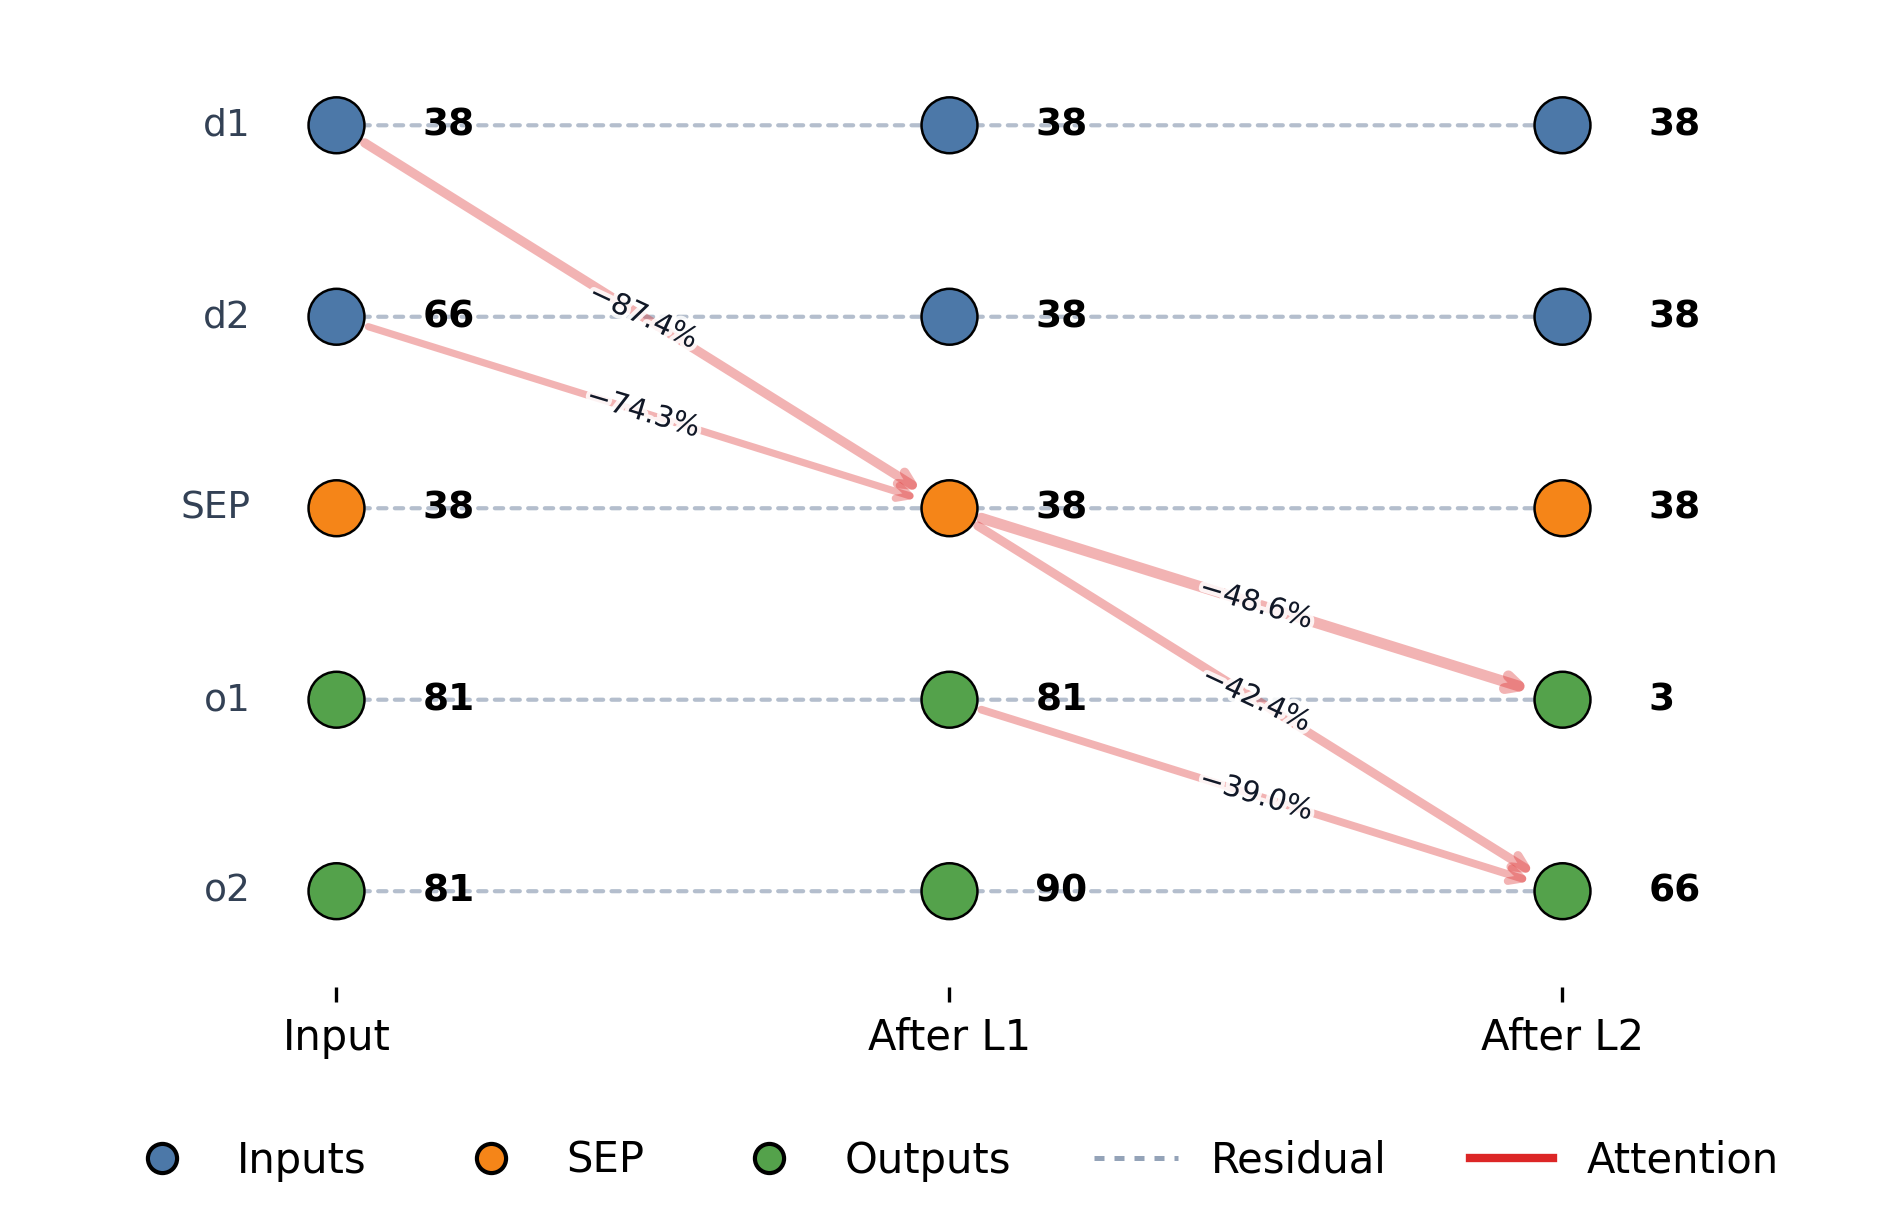

In [10]:
#  ------ Fig 1 ------

from matplotlib.patches import FancyArrowPatch
import matplotlib.patheffects as pe
from matplotlib.path import Path as MplPath  # NEW: inspect curve type

# Use a single validation example 
example = val_inputs[sample_idx].unsqueeze(0).to(DEV)

# Run and cache activations
_, cache = model.run_with_cache(example, return_type="logits")

# Collect attention patterns per layer -> shape [L, Q, K]
att = (
    torch.stack(
        [cache[f"blocks.{layer}.attn.hook_pattern"] for layer in range(model.cfg.n_layers)],
        dim=0,
    )
    .cpu()
    .numpy()
    .squeeze()
)

# prune arrows (these ones don't have any effect on the output)
if N_LAYER == 2:
    att[0][:2] = 0. * att[0][:2]
    att[1][:3] = 0. * att[1][:3]
elif N_LAYER == 3:
    ablate = {
        0: [(4, 2), (3, 2), (4, 3), (0, 0), (1, 0)],
        1: [(3, 2), (4, 3), (0, 0), (1, 0), (2, 1)],
        2: [(0, 0), (1, 0), (2, 0), (2, 1), (3, 0), (4, 0), (4, 1), (4, 2), (4, 3)],
    }
    # Vectorized assignment using numpy indexing (robust for single/multiple pairs)
    for layer, pairs in ablate.items():
        if not pairs:
            continue
        arr = np.array(pairs, dtype=int)  # shape (n_pairs, 2)
        qs = arr[:, 0]
        ks = arr[:, 1]
        att[layer, qs, ks] = 0.0

# Collect residual stream (embed + post-resid after each layer)
resid_keys = ["hook_embed"] + [f"blocks.{l}.hook_resid_post" for l in range(model.cfg.n_layers)]
resid_values = torch.stack([cache[k] for k in resid_keys], dim=0)  # [L+1, 1, seq, d_model]

# Get W_U (compatibly)
W_U = getattr(model, "W_U", model.unembed.W_U)

# Logit lens: decode most likely token at each position after each layer
position_tokens = (resid_values @ W_U).squeeze(1).argmax(-1)  # [L+1, seq]

L, N, _ = att.shape

# Layout
x_positions = np.arange(L + 1)  # columns: input + after each layer
y_positions = np.arange(N)[::-1]  # top token index = 0

# Styling for publication (vector-safe fonts for PDF/SVG)
plt.rcParams.update({
    "font.size": 10,
    "axes.titlesize": 12,
    "axes.labelsize": 10,
    "pdf.fonttype": 42,
    "ps.fonttype": 42,
})

fig, ax = plt.subplots(figsize=(6.8, 4.2), dpi=300)

# Node roles and colors
position_names = ["d1", "d2", "SEP", "o1", "o2"]
roles = ["input", "input", "sep", "output", "output"]
role_colors = {"input": "#4C78A8", "sep": "#F58518", "output": "#54A24B"}
node_colors = [role_colors[r] for r in roles]

# Draw nodes and labels (keep these on top of arrows)
for lx in range(L + 1):
    xs = np.full(N, lx)
    ax.scatter(xs, y_positions, s=180, c=node_colors,
               edgecolor="black", linewidth=0.6, zorder=4)
    # left: position label (only in first col); right: decoded token id (every col)
    for i, y in enumerate(y_positions):
        if lx == 0:
            ax.text(lx - 0.14, y, position_names[i], va="center", ha="right",
                    fontsize=9, color="#334155", zorder=5)
        ax.text(lx + 0.14, y, str(position_tokens[lx, i].item()),
                va="center", ha="left", fontsize=9, fontweight="bold",
                color="black", zorder=5)

# Residual stream (dotted straight arrows)
for lx in range(L):
    for y in y_positions:
        arrow = FancyArrowPatch((lx, y), (lx + 1, y),
                                arrowstyle="-", mutation_scale=8,
                                lw=1.0, linestyle=(0, (2, 2)), color="#94A3B8",
                                alpha=0.7, zorder=1, clip_on=False)
        ax.add_patch(arrow)

# --- Per-edge Δaccuracy placeholders ---
# Fill this dict with your measured changes in percentage points (pp).
# Key: (layer, query_idx, key_idx) where layer is 0-indexed.
# Example: delta_acc_pp[(0, 2, 0)] = -1.7  # ablating L0: q=SEP, k=d1 lowers acc by 1.7 pp
if N_LAYER == 2:
    delta_acc_pp = {
        # (l, q, k): value_in_pp,
        (0, 2, 0): -87.4, # sep --> d1
        (0, 2, 1): -74.3, # sep --> d2
        (0, 3, 2): -0.2, # o1 --> sep
        (0, 4, 2): -0.1, # o2 --> sep
        (1, 3, 2): -48.6, # o1 --> sep (L1)
        (1, 4, 2): -42.4, # o2 --> sep (L1)
        (1, 4, 3): -39.0, # o2 --> o1 (L1)
    }
elif N_LAYER == 3:
    delta_acc_pp = {
        (0, 2, 0): -1.3,
        (0, 2, 1): -49.6,
        (1, 2, 0): -49.6,
        (1, 4, 2): -49.5,
        (2, 3, 2): -49.5,
    }

def format_delta_pp(val):
    # Less obtrusive: short text, no "Δacc:" prefix
    if val is None:
        return "—"
    sign = "+" if val >= 0 else "−"
    return f"{sign}{abs(val):.1f}%"

# Attention edges (curved; width/alpha ~ weight)
threshold = 0.04  # ignore tiny weights
arrow_color = "#DC2626"   # red
arrow_alpha = 0.35        # translucent to avoid obscuring text

# Label controls
label_threshold = 0.04     # only label edges above this weight
show_placeholder = False   # set True to show "—" for missing entries
label_offset = 0.12        # distance of label from the edge midpoint

CURVE_STRENGTH = 0.0  # try 0.04–0.08; set 0.0 if you want perfectly straight

def edge_style(w):
    lw = 0.6 + 2.0 * np.sqrt(float(w))
    alpha = arrow_alpha
    return lw, alpha

def angle_in_display(ax, x0, y0, x1, y1):
    # Compute angle in screen space so rotation matches visual slope despite axis scales
    X0, Y0 = ax.transData.transform((x0, y0))
    X1, Y1 = ax.transData.transform((x1, y1))
    return np.degrees(np.arctan2(Y1 - Y0, X1 - X0))

for l in range(L):
    for q in range(N):
        for k in range(N):
            w = att[l, q, k]
            if w <= threshold:
                continue

            x0, y0 = l,      y_positions[k]
            x1, y1 = l + 1, y_positions[q]
            dy = y1 - y0

            # Curvature and style
            rad = np.sign(dy) * CURVE_STRENGTH * (min(abs(dy), 2) / 2.0)
            lw, alpha = edge_style(w)

            arrow = FancyArrowPatch(
                (x0, y0), (x1, y1),
                connectionstyle=f"arc3,rad={rad}",
                arrowstyle="->", mutation_scale=8,
                lw=lw, color=arrow_color, alpha=alpha,
                zorder=2, shrinkA=8, shrinkB=8,
                joinstyle="round", capstyle="round",
                clip_on=False,
            )
            ax.add_patch(arrow)

            # Check if a label should be drawn
            delta_val = delta_acc_pp.get((l, q, k))
            if (delta_val is None and not show_placeholder) or (w < label_threshold):
                continue
            
            label_text = format_delta_pp(delta_val)

            # --- NEW ROBUST LABEL PLACEMENT LOGIC ---

            # 1. Calculate the angle of the straight line between nodes in display space
            angle_deg = angle_in_display(ax, x0, y0, x1, y1) -8
            angle_rad = np.deg2rad(angle_deg)

            # 2. Calculate the simple midpoint of the straight line in data space
            mid_data = np.array([(x0 + x1) / 2.0, (y0 + y1) / 2.0])

            # 3. Calculate a perpendicular "nudge" vector in display space
            #    This vector points perpendicularly outwards from the line on the screen
            perp_vec_disp = np.array([-np.sin(angle_rad), np.cos(angle_rad)])
            
            # 4. Define how far to nudge the label in pixels.
            #    This is proportional to the curvature `rad`.
            #    This "magic number" controls the strength of the effect. Tune if needed.
            offset_strength_px = -400.0 
            pixel_offset = rad * offset_strength_px

            # 5. Apply the nudge in display space for visual correctness
            mid_disp = ax.transData.transform(mid_data)
            label_pos_disp = mid_disp + pixel_offset * perp_vec_disp
            
            # 6. Transform the final label position back to data space
            lx, ly = ax.transData.inverted().transform(label_pos_disp)

            # 7. Annotate at the final calculated position
            ann = ax.annotate(
                label_text,
                xy=(lx, ly),
                ha="center",
                va="center",
                fontsize=7,
                color="#111827",
                rotation=angle_deg, # Rotate to match the chord
                rotation_mode="anchor",
                zorder=4.2,
                clip_on=False,
            )
            ann.set_path_effects([pe.withStroke(linewidth=2.0, foreground="white", alpha=0.85)])
         
# Axes cosmetics
ax.set_xlim(-0.5, L + 0.5)
ax.set_ylim(-0.5, N - 0.5)
ax.set_xticks(x_positions)
ax.set_xticklabels(["Input"] + [f"After L{l+1}" for l in range(L)])
ax.set_yticks([])  # we draw our own labels
for spine in ax.spines.values():
    spine.set_visible(False)

# Legend (update attention color to red)
legend_elements = [
    Line2D([0], [0], marker="o", color="w", label="Inputs",
           markerfacecolor=role_colors["input"], markeredgecolor="black", markersize=7),
    Line2D([0], [0], marker="o", color="w", label="SEP",
           markerfacecolor=role_colors["sep"], markeredgecolor="black", markersize=7),
    Line2D([0], [0], marker="o", color="w", label="Outputs",
           markerfacecolor=role_colors["output"], markeredgecolor="black", markersize=7),
    Line2D([0], [0], linestyle=(0, (2, 2)), color="#94A3B8", lw=1.2, label="Residual"),
    Line2D([0], [0], color=arrow_color, lw=2, label="Attention"),
]
ax.legend(handles=legend_elements, frameon=False, ncol=5,
          loc="upper center", bbox_to_anchor=(0.5, -0.12))

plt.tight_layout()
plt.show()


### Mean Attention Patterns

In [11]:
# --- Mean Attention Patterns ---

all_pats = [[] for _ in range(model.cfg.n_layers)]
for inputs, _ in val_dl:
    with torch.no_grad():
        _, cache = model.run_with_cache(inputs.to(DEV))
    for l in range(model.cfg.n_layers):
        pat = cache["pattern", l][:, 0]  # (batch, Q, K)
        all_pats[l].append(pat)
all_pats = [torch.cat(pats, dim=0) for pats in all_pats]

for l, pats in enumerate(all_pats):
    identical = torch.allclose(pats, pats[0].expand_as(pats))
    print(f"Layer {l}: all attention patterns identical? {'✅' if identical else '❌'}")

with torch.no_grad():
    avg_pats = [
        torch.zeros(SEQ_LEN, SEQ_LEN, device=DEV) for _ in range(model.cfg.n_layers)
    ]
    n = 0
    for inputs, _ in val_dl:
        _, cache = model.run_with_cache(inputs.to(DEV))
        for l in range(model.cfg.n_layers):
            avg_pats[l] += cache["pattern", l][:, 0].sum(0)
        n += inputs.shape[0]
    avg_pats = [p / n for p in avg_pats]


# Create a deep copy of the model to avoid modifying the original
model_with_avg_attn = copy.deepcopy(model)

def mk_hook(avg):
    logits = (avg + 1e-12).log()  # log-prob so softmax≈avg, ε avoids -∞

    def f(scores, hook):
        return logits.unsqueeze(0).unsqueeze(0).expand_as(scores)

    return f

for l in range(model_with_avg_attn.cfg.n_layers):
    model_with_avg_attn.blocks[l].attn.hook_attn_scores.add_hook(
        mk_hook(avg_pats[l]), dir="fwd"
    )

print("Accuracy with avg-attn:", accuracy(model_with_avg_attn))

Layer 0: all attention patterns identical? ❌
Layer 1: all attention patterns identical? ❌
Accuracy with avg-attn: 0.4465


Using the mean attention pattern destroys performance.

Earlier research found that RNNs use a fixed attention pattern where the embeddings are projected into an "onion ring" pattern. However, in our model, the attention pattern to each of the input tokens is roughly normally distributed, for each of the positions (though always summing to 1).


### Ablation of specific attn edges

In [12]:
# ---- Ablation of Specific Attention Edges ----

renorm_rows = False # whether to renormalize rows after ablation
ablate_in_l0 = [
                (4,3),
                (0,0),
                (1,0)
                ]
ablate_in_l1 = [
                (0,0),
                (1,0),
                (2,0),
                (2,1),
                ]

ablate_in_l2 = [(0,0),(1,0),(2,0), (2,1), (3,0),  (4,0), (4,1), (4,2), (4,3)]

# Try ablating multiple layer attention patterns at same time
def build_qk_mask(positions=None, queries=None, keys=None, seq_len=SEQ_LEN):
    """
    Create a boolean mask of shape (seq_len, seq_len) where True means "ablate this (q,k)".
    You can pass:
      - positions: list of (q, k) tuples
      - or queries: iterable of q, and keys: iterable of k (outer-product mask)
    """
    mask = torch.zeros(seq_len, seq_len, dtype=torch.bool)
    if positions is not None:
        for q, k in positions:
            mask[q, k] = True
    else:
        if queries is None:
            queries = range(seq_len)
        if keys is None:
            keys = range(seq_len)
        for q in queries:
            mask[q, keys] = True
    return mask

def make_pattern_hook(mask_2d: torch.Tensor, head_index=None, set_to=0.0, renorm=True, eps=1e-12):
    """
    Returns a fwd hook for the 'pattern' activation that:
      - sets masked entries to set_to (default 0.0)
      - optionally renormalizes rows so they sum to 1 again (per head, per batch, per query row)
    Args:
      mask_2d: Bool tensor [Q, K]
      head_index: int to affect a single head, or None to affect all heads
      set_to: value to write into masked entries (usually 0.0)
      renorm: whether to renormalize rows after masking
    """
    mask_2d = mask_2d.detach()

    def hook(pattern, hook):
        # pattern: [batch, n_heads, Q, K]
        B, H, Q, K = pattern.shape
        m4_all = mask_2d.to(pattern.device).view(1, 1, Q, K)  # broadcastable
        # Keep a copy for safe fallback in renorm
        pre = pattern.clone()
        print(f"\nLayer {hook.layer()} Ablation")
        print(f'BEFORE Ablation:\n{pattern[sample_idx, head_index, :, :].cpu().numpy()}')
        # print(f'Mask:\n{m4_all[0, 0, :, :].cpu().numpy()}')
        

        if head_index is None:
            pattern = torch.where(m4_all, torch.as_tensor(set_to, device=pattern.device), pattern)
        else:
            m3 = m4_all.squeeze(1)  # [1, Q, K]
            ph = pattern[:, head_index]  # [B, Q, K]
            ph = torch.where(m3, torch.as_tensor(set_to, device=pattern.device), ph)
            pattern[:, head_index] = ph

        if renorm:
            # Renormalize only rows whose query index has any masked key
            rows_to_fix = mask_2d.any(dim=-1)  # [Q]
            if rows_to_fix.any():
                rows_idx = rows_to_fix.nonzero(as_tuple=False).squeeze(-1)  # [Nr]
                heads = range(H) if head_index is None else [head_index]
                for h in heads:
                    # p: [B, Nr, K]
                    p = pattern[:, h, rows_idx, :]
                    s = p.sum(dim=-1, keepdim=True).clamp_min(eps)   # [B, Nr, 1]
                    pattern[:, h, rows_idx, :] = p / s

        print(f'AFTER Ablation:\n{pattern[sample_idx, head_index, :, :].cpu().numpy()}')
        return pattern

    return hook

# Example usage:
# Define what to ablate per layer:
# - As explicit (q,k) pairs
# - Or as queries/keys sets (outer-product)
layers_to_ablate = {
    0: build_qk_mask(positions=ablate_in_l0, seq_len=SEQ_LEN),
    1: build_qk_mask(positions=ablate_in_l1, seq_len=SEQ_LEN),
    # 2: build_qk_mask(positions=ablate_in_l2, seq_len=SEQ_LEN),
}

# Apply to a single head or all heads
head = None  # Set to None to affect all heads, or specify a head index (e.g., 0)

# Build hooks
fwd_hooks = []
for layer_idx, mask in layers_to_ablate.items():
    hook_name = utils.get_act_name("pattern", layer_idx)
    fwd_hooks.append((hook_name, make_pattern_hook(mask, head_index=head, set_to=0.0, renorm=renorm_rows)))

# Run with hooks and evaluate on last two positions
with torch.no_grad():
    logits_multi = model.run_with_hooks(val_inputs, return_type="logits", fwd_hooks=fwd_hooks)

output_logits_multi = logits_multi[:, LIST_LEN+1:]
ablated_output_predictions = output_logits_multi.argmax(dim=-1)
output_targets = val_targets[:, LIST_LEN+1:]

ablated_loss = loss_fn(output_logits_multi.reshape(-1, VOCAB), val_targets[:, LIST_LEN+1:].reshape(-1))
ablated_acc = (ablated_output_predictions == val_targets[:, LIST_LEN+1:]).float().mean()

print("\n--- Performance Metrics ---")
print(f"Multi-layer attention ablation -> Loss: {ablated_loss.item():.3f}, Acc: {ablated_acc.item():.3f}")

# Optional: inspect a sample
idx = sample_idx
print("Sample sequence:", val_inputs[idx].cpu().numpy())
print("Original:", original_predictions[idx].cpu().numpy())
print("Ablated: ", logits_multi.argmax(dim=-1)[idx].cpu().numpy())


Layer 0 Ablation
BEFORE Ablation:
[[[[1.00000 0.00000 0.00000 0.00000 0.00000]
   [1.00000 0.00000 0.00000 0.00000 0.00000]
   [0.68226 0.31774 0.00000 0.00000 0.00000]
   [0.00000 0.00000 0.00000 0.00000 0.00000]
   [0.00000 0.00000 0.00000 0.00000 0.00000]]]]
AFTER Ablation:
[[[[0.00000 0.00000 0.00000 0.00000 0.00000]
   [0.00000 0.00000 0.00000 0.00000 0.00000]
   [0.68226 0.31774 0.00000 0.00000 0.00000]
   [0.00000 0.00000 0.00000 0.00000 0.00000]
   [0.00000 0.00000 0.00000 0.00000 0.00000]]]]

Layer 1 Ablation
BEFORE Ablation:
[[[[1.00000 0.00000 0.00000 0.00000 0.00000]
   [1.00000 0.00000 0.00000 0.00000 0.00000]
   [1.00000 0.00000 0.00000 0.00000 0.00000]
   [0.00000 0.00000 1.00000 0.00000 0.00000]
   [0.00000 0.00000 0.59858 0.40142 0.00000]]]]
AFTER Ablation:
[[[[0.00000 0.00000 0.00000 0.00000 0.00000]
   [0.00000 0.00000 0.00000 0.00000 0.00000]
   [0.00000 0.00000 0.00000 0.00000 0.00000]
   [0.00000 0.00000 1.00000 0.00000 0.00000]
   [0.00000 0.00000 0.59858 0.4014

In [13]:
# Analyse errors from the ablated model wrt o_2

def analyze_o2_errors(preds, targets, inputs=None, top_k=10):
    """
    preds, targets: [B, 2] (o1, o2)
    inputs: [B, 5] full token seq [d1, d2, SEP, o1, o2] (optional)
    """
    assert preds.shape == targets.shape and preds.ndim == 2 and preds.shape[1] == 2
    B = preds.shape[0]
    o1_pred, o2_pred = preds[:, 0], preds[:, 1]
    o1_true, o2_true = targets[:, 0], targets[:, 1]

    o2_wrong_mask = (o2_pred != o2_true)
    num_o2_wrong = int(o2_wrong_mask.sum().item())
    if num_o2_wrong == 0:
        print("No o2 errors.")
        return

    # Relations to o1
    dupes_rate = (o2_pred[o2_wrong_mask] == o1_pred[o2_wrong_mask]).float().mean().item()
    equals_o1_true_rate = (o2_pred[o2_wrong_mask] == o1_true[o2_wrong_mask]).float().mean().item()
    o1_correct_given_o2_wrong = (o1_pred[o2_wrong_mask] == o1_true[o2_wrong_mask]).float().mean().item()

    # Relations to inputs (if provided)
    if inputs is not None:
        d1, d2 = inputs[:, 0], inputs[:, 1]
        eq_d1 = int((o2_pred[o2_wrong_mask] == d1[o2_wrong_mask]).sum().item())
        eq_d2 = int((o2_pred[o2_wrong_mask] == d2[o2_wrong_mask]).sum().item())
    else:
        eq_d1 = eq_d2 = None

    # Frequency of o2 predictions when wrong
    vals = o2_pred[o2_wrong_mask]
    counts = torch.bincount(vals, minlength=VOCAB).cpu()
    top_idx = counts.argsort(descending=True)[:top_k]
        

    def tok_label(t):
        t = int(t)
        if t < N_DIGITS: return f"{t}"
        if t == MASK: return "MASK"
        if t == SEP: return "SEP"
        return f"tok{t}"

    print(f"o2 wrong: {num_o2_wrong}/{B} ({num_o2_wrong/B:.2%})")
    print(f"P(o2_pred == o1_pred | o2 wrong): {dupes_rate:.2%}")
    print(f"P(o2_pred == o1_true | o2 wrong): {equals_o1_true_rate:.2%}")
    print(f"P(o1 correct | o2 wrong): {o1_correct_given_o2_wrong:.2%}")
    if eq_d1 is not None:
        print(f"P(o2_pred == d1 | o2 wrong): {eq_d1/num_o2_wrong:.2%} ({eq_d1})")
        print(f"P(o2_pred == d2 | o2 wrong): {eq_d2/num_o2_wrong:.2%} ({eq_d2})")

    print("\nTop o2 predictions when wrong:")
    for t in top_idx.tolist():
        c = int(counts[t].item())
        if c == 0: continue
        print(f"  {tok_label(t):>4}: {c} ({c/num_o2_wrong:.2%})")

    # Show a few concrete examples
    show = min(5, num_o2_wrong)
    idxs = torch.nonzero(o2_wrong_mask).squeeze(-1)[:show].cpu().tolist()
    print("\nExamples (d1,d2) -> (o1_true,o2_true) | (o1_pred,o2_pred):")
    for i in idxs:
        if inputs is not None:
            d1i, d2i = int(inputs[i, 0]), int(inputs[i, 1])
            left = f"({d1i},{d2i}) -> ({int(o1_true[i])},{int(o2_true[i])})"
        else:
            left = f"-> ({int(o1_true[i])},{int(o2_true[i])})"
        print(f"  {left} | ({int(o1_pred[i])},{int(o2_pred[i])})")

analyze_o2_errors(ablated_output_predictions, output_targets, inputs=val_inputs)

o2 wrong: 277/2000 (13.85%)
P(o2_pred == o1_pred | o2 wrong): 94.58%
P(o2_pred == o1_true | o2 wrong): 99.64%
P(o1 correct | o2 wrong): 94.95%
P(o2_pred == d1 | o2 wrong): 99.64% (276)
P(o2_pred == d2 | o2 wrong): 0.00% (0)

Top o2 predictions when wrong:
    60: 8 (2.89%)
    90: 7 (2.53%)
     4: 6 (2.17%)
    21: 6 (2.17%)
    10: 6 (2.17%)
    86: 6 (2.17%)
     1: 5 (1.81%)
    62: 5 (1.81%)
    67: 5 (1.81%)
    70: 5 (1.81%)

Examples (d1,d2) -> (o1_true,o2_true) | (o1_pred,o2_pred):
  (90,79) -> (90,79) | (79,90)
  (7,29) -> (7,29) | (7,7)
  (67,2) -> (67,2) | (67,67)
  (14,47) -> (14,47) | (14,14)
  (71,27) -> (71,27) | (71,71)


## Circuit Analysis

In [14]:
# ---- constants for equation ----
# Get attention patterns for both layers on the validation set

with torch.no_grad():
    logits, cache = model.run_with_cache(val_inputs)
    dig_logits = logits[:,:,:-2]  # exclude SEP and mask token logits
    b_size = dig_logits.shape[0]  # batch size

# get required attention values
alpha = cache["pattern", 0][:, head_index_to_ablate]  # Layer 0
beta = cache["pattern", 1][:, head_index_to_ablate]   # Layer 1
alpha_sep_d1 = alpha[:,2, 0].unsqueeze(-1)  # SEP -> d1
alpha_sep_d2 = alpha[:,2, 1].unsqueeze(-1)  # SEP -> d2
beta_o2_o1 = beta[:,-1, -2].unsqueeze(-1)
beta_o2_sep = beta[:,-1, 2].unsqueeze(-1) # beta_o2_o1 + beta_o2_sep = 1.0

# Weights and embeddings
W_E = model.W_E.detach()  # (vocab, d_model)
W_pos = model.W_pos.detach()  # (seq_len, d_model)
W_U = model.unembed.W_U.detach()  # (d_model, vocab)

# Input tokens for d1, d2
d1_tok = val_inputs[:, 0]
d2_tok = val_inputs[:, 1]

# get embeds
big_d1 = W_E[d1_tok] + W_pos[0,:]  # d1 embedding (d_model)
big_d2 = W_E[d2_tok] + W_pos[1,:] # d2 embedding (d_model)
pos_o1 = W_pos[-2,:]  # o1 position (d_model)
pos_o2 = W_pos[-1,:]  # o2 position (d_model)
mask_embed = W_E[MASK]  # (d_model)
sep_embed = W_E[SEP] + W_pos[2,:]  # SEP token embedding (d_model)

# get shapes right
pos_o1 = pos_o1.expand(b_size, -1)
pos_o2 = pos_o2.expand(b_size, -1)
mask_embed = mask_embed.expand(b_size, -1)
sep_embed = sep_embed.expand(b_size, -1)

# print("mask_embed shape:", mask_embed.shape)
# print("sep_embed shape:", sep_embed.shape)
# print("pos_o1 shape:", pos_o1.shape)
# print("pos_o2 shape:", pos_o2.shape)
# print("big_d1 shape:", big_d1.shape)
# print("big_d2 shape:", big_d2.shape)
# print("alpha_sep_d1 shape:", alpha_sep_d1.shape)
# print("alpha_sep_d2 shape:", alpha_sep_d2.shape)
# print("beta_o2_o1 shape:", beta_o2_o1.shape)
# print("beta_o2_sep shape:", beta_o2_sep.shape)

# verify by reconstructing logits

l_o1 = (mask_embed + sep_embed + pos_o1 + alpha_sep_d1*big_d1+ alpha_sep_d2*big_d2) @ W_U  # logits for o1 (d_model)
l_o1_digits = l_o1[:, :N_DIGITS]
patched_o1_logits = l_o1_digits.argmax(dim=-1)
acc_patched_o1 = (patched_o1_logits == val_targets[:, -2]).float().mean().item()

l_o2 = ((1+beta_o2_o1)*mask_embed + beta_o2_o1*pos_o1 + pos_o2 + beta_o2_sep*(alpha_sep_d1*big_d1 + alpha_sep_d2*big_d2 + sep_embed)) @ W_U  # logits for o2 (d_model)
l_o2_digits = l_o2[:, :N_DIGITS]
patched_o2_logits = l_o2_digits.argmax(dim=-1)
acc_patched_o2 = (patched_o2_logits == val_targets[:, -1]).float().mean().item()


# Compare reconstructed logits to model logits for o2
with torch.no_grad():
    model_o2_logits = logits[:, -1, :N_DIGITS]  # [B, N_DIGITS]
    l2_diff = ((l_o2_digits - model_o2_logits).norm(dim=-1).mean().item())
    print(f"Mean L2 diff between reconstructed and model o2 logits: {l2_diff:.4f}")

print(f'\nReconstructed accuracy: {(acc_patched_o1 + acc_patched_o2) / 2.0:.3f}')

Mean L2 diff between reconstructed and model o2 logits: 0.0001

Reconstructed accuracy: 0.920


Great! This suggests we have successfully reconstructed the logits as the accuracy is the same using the reconstructed logits to make predictions.

In [15]:
# --- Logit Difference Calculation ---
# scale constants
scaled_pos_o1 = -beta_o2_sep * pos_o1
scaled_big_d1 = -beta_o2_o1 * alpha_sep_d1 * big_d1
scaled_big_d2 = -beta_o2_o1 * alpha_sep_d2 * big_d2
scaled_sep_embed = -beta_o2_o1 * sep_embed
scaled_mask_embed = beta_o2_o1 * mask_embed

# logit_o2 - logit_o1
logit_diff = pos_o2 + scaled_pos_o1 + scaled_big_d1 + scaled_big_d2 + scaled_sep_embed + scaled_mask_embed
logit_diff = (logit_diff @ W_U )[:,:-2]  # exclude sep and mask token logits


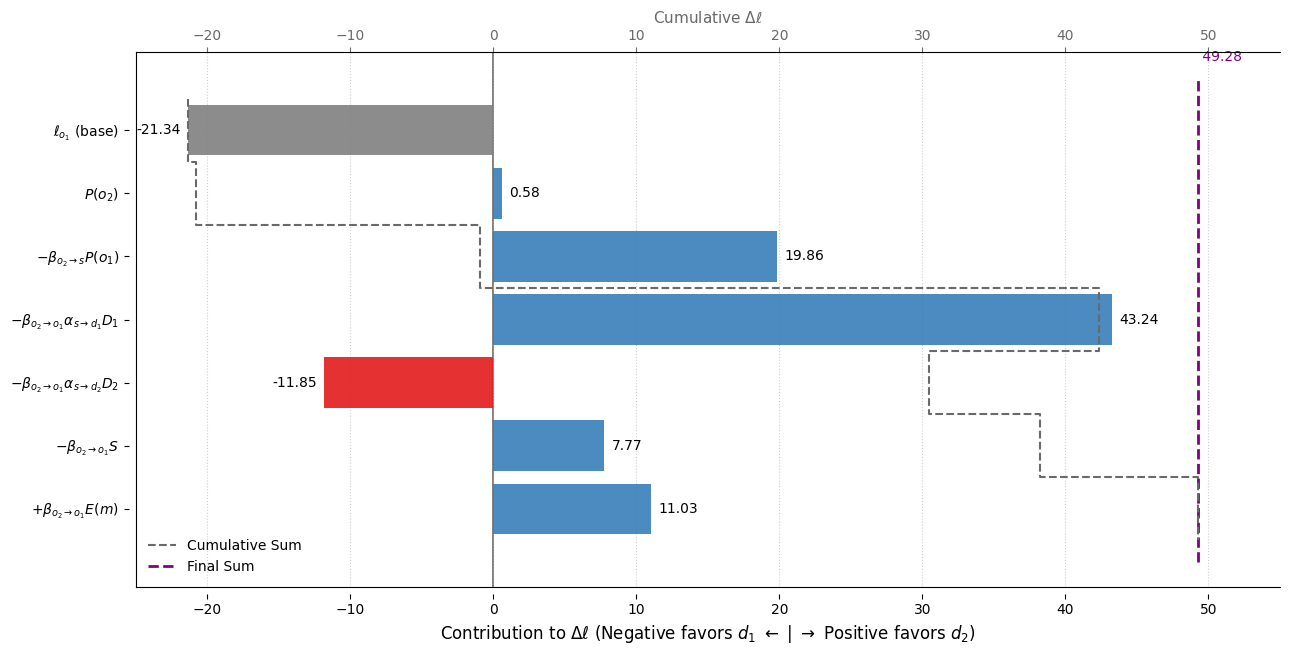

In [16]:
# ----- Fig 2 - Logit Difference Contributions -----

# get embeds in d_model space
term_pos_o2 = W_pos[-1,:].expand(b_size, -1)
term_pos_o1 = -beta_o2_sep * W_pos[-2,:].expand(b_size, -1)
term_big_d1 = -beta_o2_o1 * alpha_sep_d1 * (W_E[d1_tok] + W_pos[0,:])
term_big_d2 = -beta_o2_o1 * alpha_sep_d2 * (W_E[d2_tok] + W_pos[1,:])
term_sep = -beta_o2_o1 * (W_E[SEP] + W_pos[2,:]).expand(b_size, -1)
term_mask = beta_o2_o1 * W_E[MASK].expand(b_size, -1)


# Define number of digits from logit shape
N_DIGITS = dig_logits.shape[-1]

# Helper to project d_model vectors to logit space for N_DIGITS
def unembed_digits(x):
    return (x @ W_U)[:, :N_DIGITS]

# Unembed all our terms into logit-space contributions
base_o1_digits = logits[:, -2, :N_DIGITS]
contrib_pos_o2 = unembed_digits(term_pos_o2)
contrib_pos_o1 = unembed_digits(term_pos_o1)
contrib_big_d1 = unembed_digits(term_big_d1)
contrib_big_d2 = unembed_digits(term_big_d2)
contrib_sep = unembed_digits(term_sep)
contrib_mask = unembed_digits(term_mask)

# Helper to gather the specific logits for d1 and d2 from a logit matrix
def gather_pair_cols(logits, d1, d2):
    # logits: [B, N_DIGITS], d1: [B], d2: [B]
    d1_logits = logits.gather(-1, d1.unsqueeze(-1))
    d2_logits = logits.gather(-1, d2.unsqueeze(-1))
    return torch.cat([d1_logits, d2_logits], dim=-1) # -> [B, 2]

# Define the mask for the specific cases we're analyzing (where target_o2 is d2)
# This assumes `val_targets` (shape [batch, seq_len]) is defined.
tgt_o2 = val_targets[:, -1]
mask_unique = (d1_tok != d2_tok) & ((tgt_o2 == d1_tok) | (tgt_o2 == d2_tok))
m = mask_unique & (tgt_o2 == d2_tok)

# Calculate the final scalar values required for the plot
base_diff_d2_d1 = (
    gather_pair_cols(base_o1_digits[m], d1_tok[m], d2_tok[m])[:, 1] - 
    gather_pair_cols(base_o1_digits[m], d1_tok[m], d2_tok[m])[:, 0]
).mean().cpu()

contribs_list = [contrib_pos_o2, contrib_pos_o1, contrib_big_d1, contrib_big_d2, contrib_sep, contrib_mask]
diff_contributions = []
for c in contribs_list:
    c_d2 = gather_pair_cols(c[m], d1_tok[m], d2_tok[m])[:, 1]
    c_d1 = gather_pair_cols(c[m], d1_tok[m], d2_tok[m])[:, 0]
    diff_contributions.append((c_d2 - c_d1).mean().item())

final_calc_diff = base_diff_d2_d1 + sum(diff_contributions)



fig, ax = plt.subplots(figsize=(13, 7))

# Labels for the plot, matching the paper's notation
base_name = r'$\ell_{o_1}$ (base)'
contrib_names = [
    r'$P(o_2)$', r'$-\beta_{o_2 \to s} P(o_1)$', r'$-\beta_{o_2 \to o_1}\alpha_{s \to d_1}D_1$',
    r'$-\beta_{o_2 \to o_1}\alpha_{s \to d_2}D_2$', r'$-\beta_{o_2 \to o_1}S$', r'$+\beta_{o_2 \to o_1}E(m)$'
]

# Combine base and contribution data for plotting
all_names = [base_name] + contrib_names
all_values = [base_diff_d2_d1.item()] + diff_contributions
step_plot_values = np.insert(np.cumsum(all_values), 0, base_diff_d2_d1.item())
colors = ['grey'] + ['#377eb8' if v > 0 else '#e41a1c' for v in diff_contributions]

# Plot the main horizontal bars
bars = ax.barh(all_names, all_values, color=colors, alpha=0.9, zorder=2)
ax.invert_yaxis()

# Add text annotations for the value of each bar
for bar, value in zip(bars, all_values):
    ha = 'left' if value >= 0 else 'right'
    offset = 0.5
    ax.text(bar.get_width() + (offset if value >= 0 else -offset), bar.get_y() + bar.get_height()/2,
            f'{value:.2f}', va='center', ha=ha, fontsize=10)

# Create and configure the top axis for the cumulative sum step plot
ax_top = ax.twiny()
y_steps = np.arange(len(all_names) + 1) - 0.5
step_line, = ax_top.step(step_plot_values, y_steps, color='dimgray', where='post', 
                         linestyle='--', linewidth=1.5, label='Cumulative Sum')
ax_top.set_xlabel(r"Cumulative $\Delta\ell$", fontsize=11, color='dimgray')
ax_top.tick_params(axis='x', colors='dimgray')

# Manually draw the final sum line for robustness
y_limits = ax.get_ylim()
final_line, = ax.plot([final_calc_diff, final_calc_diff], y_limits, 
                       color='purple', linestyle='--', linewidth=2, 
                       label='Final Sum', zorder=10)
ax.text(final_calc_diff, y_limits[1] - 0.2, f' {final_calc_diff:.2f}', color='purple', 
        ha='left', va='bottom', fontsize=10)

# Create a combined legend for elements from both axes
handles = [step_line, final_line]
ax.legend(handles=handles, frameon=False, loc="lower left", fontsize=10)

# --- Final Aesthetics and Layout ---
ax.set_xlabel(r"Contribution to $\Delta\ell$ (Negative favors $d_1$ $\leftarrow$ | $\rightarrow$ Positive favors $d_2$)", fontsize=12)
ax.grid(axis='x', linestyle=':', alpha=0.6, zorder=1)
ax.axvline(0, color='dimgray', linestyle='-', linewidth=1.2, zorder=1)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.spines['bottom'].set_position(('outward', 5))
ax.spines['left'].set_position(('outward', 5))
ax_top.spines['top'].set_position(('outward', 0))
ax_top.spines['right'].set_visible(False)
ax_top.tick_params(axis='y', right=False, labelright=False)
plt.yticks(fontsize=12)

# Set axis limits and apply tight layout
ax.set_xlim(left=-25, right=55)
ax_top.set_xlim(ax.get_xlim()) 
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()

## Linearly Separable Unembedding Matrix


The projections of the last and second-to-last token vectors onto the positional dimensions are linearly separable, revealing that this composition of positional encodings is key to separating the tokens back out.

In [17]:
# Ensure we have a cache to use in the analysis
with torch.no_grad():
    logits, cache = model.run_with_cache(val_inputs, return_type="logits")

# Residuals: [batch, seq, d_model] or [seq, d_model]
resid = cache["resid_post", 1].detach().cpu().numpy()
if resid.ndim == 2:  # no batch
    resid = resid[None, ...]
if resid.shape[1] < 2:
    raise ValueError("Need sequence length >= 2 to compare -1 and -2.")

# Last and second-to-last token vectors
vecs_last = resid[:, -1, :]  # [B, d_model] -> o2 (last)
vecs_prev = resid[:, -2, :]  # [B, d_model] -> o1 (second-last)

# Positional matrix and projections
W_pos = model.W_pos.detach().cpu().numpy()
projs_last = (vecs_last @ W_pos.T)[:]
projs_prev = (vecs_prev @ W_pos.T)[:]

with torch.no_grad():
    # Least-squares projection onto span(W_pos) before unembedding
    # projs_last/prev are (B, n_pos) = vec @ W_pos.T
    W_pos_t = model.W_pos.cpu()                         # [n_pos, d_model]
    G = W_pos_t @ W_pos_t.T                             # [n_pos, n_pos]
    G_inv = torch.linalg.pinv(G)                        # robust pseudo-inverse

    last_coeffs = torch.from_numpy(projs_last).to(W_pos_t.dtype) @ G_inv  # (B, n_pos)
    prev_coeffs = torch.from_numpy(projs_prev).to(W_pos_t.dtype) @ G_inv  # (B, n_pos)

    last_proj = last_coeffs @ W_pos_t                   # (B, d_model)
    prev_proj = prev_coeffs @ W_pos_t                   # (B, d_model)

    last_pos_projs_unembed = last_proj @ model.W_U.cpu()  # (B, vocab)
    prev_pos_projs_unembed = prev_proj @ model.W_U.cpu()  # (B, vocab)


In [18]:
# --- SVM analysis ---
from sklearn.svm import SVC

# X: points, y: labels
X = np.vstack([projs_last, projs_prev])
y = np.hstack([np.ones(len(projs_last)), -np.ones(len(projs_prev))])

# hard-margin SVM via large C
clf = SVC(kernel="linear", C=1e6).fit(X, y)

separable = clf.score(X, y) > 0.99
print("Linearly separable:", separable)

if separable:
    w = clf.coef_[0]
    b = clf.intercept_[0]
    margin = 1.0 / np.linalg.norm(w)
    print("Margin:", margin)

Linearly separable: True
Margin: 5.653254503567782


# Appendices

## D - Attention

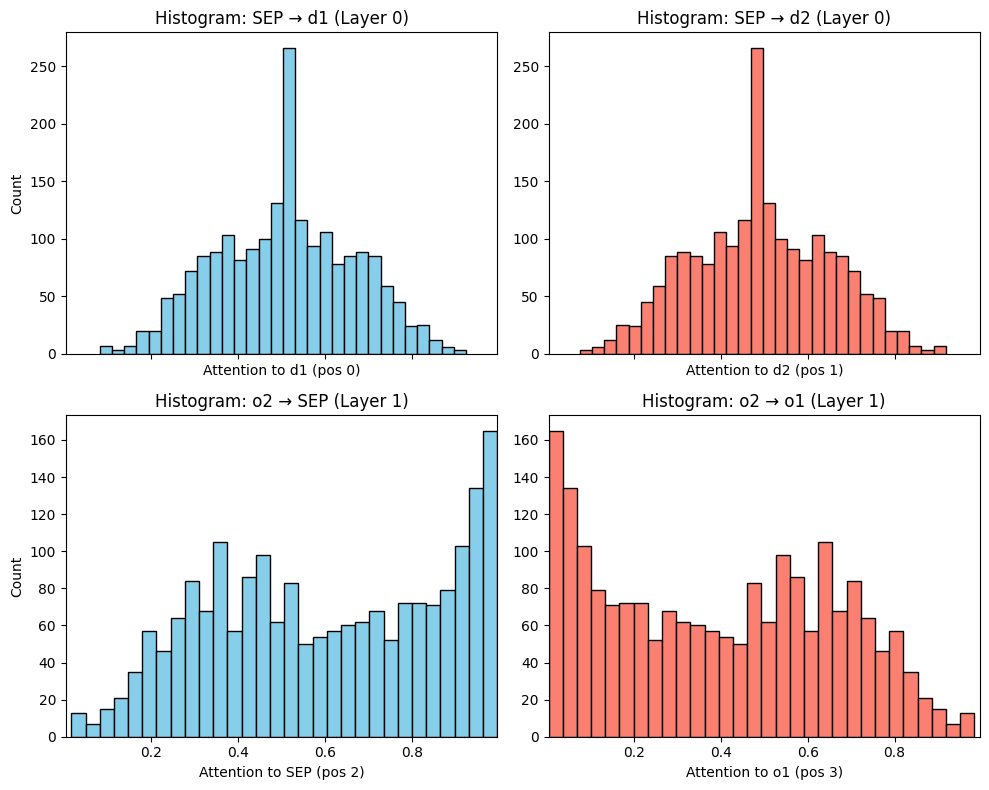

In [19]:
# ----- Fig 4 - Attn histogram -----

# Extract attention weights (reuse existing cache)
attn_sep_d1 = cache["pattern", 0].squeeze()[:, 2, 0].cpu().numpy()
attn_sep_d2 = cache["pattern", 0].squeeze()[:, 2, 1].cpu().numpy()
attn_o2_sep = cache["pattern", 1].squeeze()[:, -1, 2].cpu().numpy()
attn_o2_o1  = cache["pattern", 1].squeeze()[:, -1, 3].cpu().numpy()

# Compute global x-range across all histograms
all_vals = np.concatenate([attn_sep_d1, attn_sep_d2, attn_o2_sep, attn_o2_o1])
x_min, x_max = float(all_vals.min()), float(all_vals.max())

fig, axes = plt.subplots(2, 2, figsize=(10, 8), sharex=True)

# Row 1
ax = axes[0, 0]
ax.hist(attn_sep_d1, bins=30, color="skyblue", edgecolor="black")
ax.set_xlabel("Attention to d1 (pos 0)")
ax.set_ylabel("Count")
ax.set_title("Histogram: SEP → d1 (Layer 0)")

ax = axes[0, 1]
ax.hist(attn_sep_d2, bins=30, color="salmon", edgecolor="black")
ax.set_xlabel("Attention to d2 (pos 1)")
ax.set_ylabel("")
ax.set_title("Histogram: SEP → d2 (Layer 0)")

# Row 2
ax = axes[1, 0]
ax.hist(attn_o2_sep, bins=30, color="skyblue", edgecolor="black")
ax.set_xlabel("Attention to SEP (pos 2)")
ax.set_ylabel("Count")
ax.set_title("Histogram: o2 → SEP (Layer 1)")

ax = axes[1, 1]
ax.hist(attn_o2_o1, bins=30, color="salmon", edgecolor="black")
ax.set_xlabel("Attention to o1 (pos 3)")
ax.set_ylabel("")
ax.set_title("Histogram: o2 → o1 (Layer 1)")

# Apply the shared x-limits to all axes
for ax in axes.flat:
    ax.set_xlim(x_min, x_max)

# Make y-axes the same within each row
ymax_row0 = max(axes[0, 0].get_ylim()[1], axes[0, 1].get_ylim()[1])
ymax_row1 = max(axes[1, 0].get_ylim()[1], axes[1, 1].get_ylim()[1])
axes[0, 0].set_ylim(0, ymax_row0)
axes[0, 1].set_ylim(0, ymax_row0)
# axes[0,1].set_yticks([])
axes[1, 0].set_ylim(0, ymax_row1)
axes[1, 1].set_ylim(0, ymax_row1)
# axes[1,1].set_yticks([])

plt.tight_layout()
plt.show()

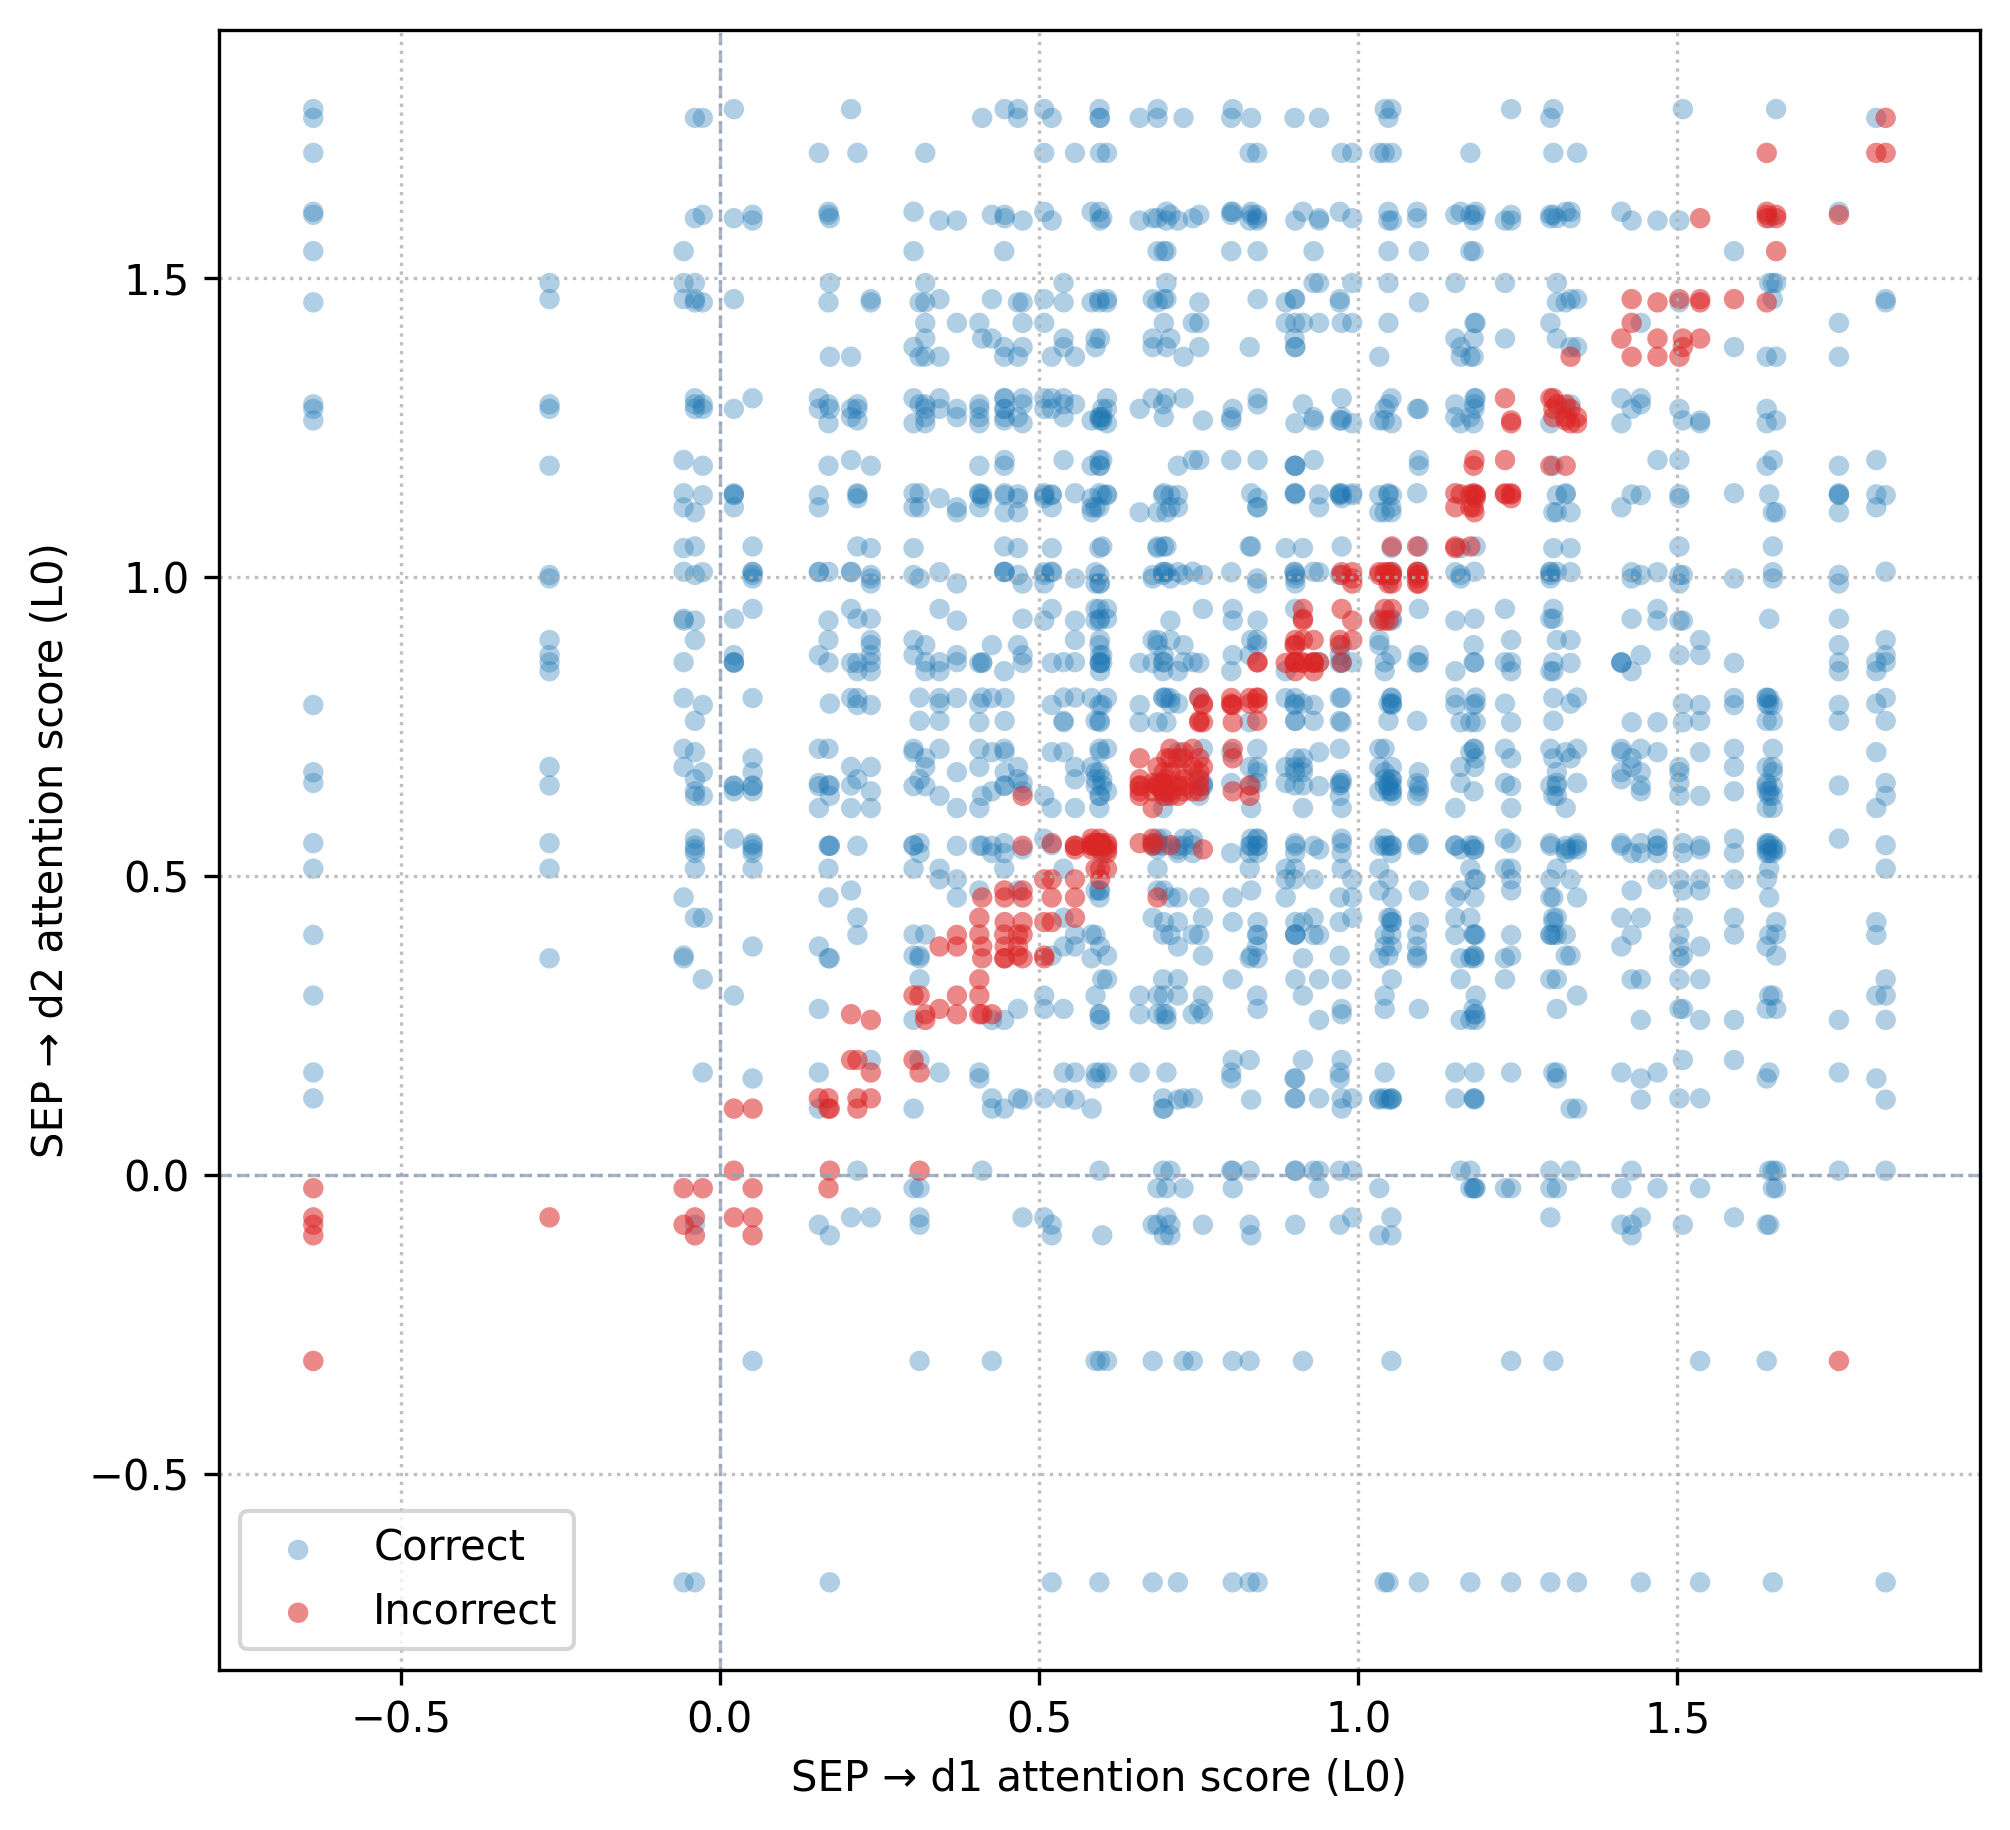

Total samples: 2000
Correct predictions: 1693
Accuracy: 0.847


In [20]:
# ------ Fig 5 - SEP attn vs accuracy ------

# Run model on all validation data
all_inputs = val_ds.tensors[0].to(DEV)
all_targets = val_ds.tensors[1].to(DEV)
with torch.no_grad():
    all_logits, all_cache = model.run_with_cache(all_inputs, return_type="logits")

# Correctness per sample (both outputs correct)
all_predictions = all_logits.argmax(dim=-1)[:, -LIST_LEN:]
all_correct = (all_predictions == all_targets[:, -LIST_LEN:]).all(dim=-1).cpu().numpy()

# Extract attention SCORES: Layer 0, q=SEP (2), k∈{d1=0, d2=1}
scores_l0 = all_cache["attn_scores", 0][:, 0]  # [B, Q, K] (head=0)
attn_vals = scores_l0[:, 2, [0, 1]].detach().cpu().numpy()  # [B, 2]
x, y = attn_vals[:, 0], attn_vals[:, 1]
ok = all_correct.astype(bool)
x_ok, y_ok = x[ok], y[ok]
x_bad, y_bad = x[~ok], y[~ok]

# Axes limits (robust to outliers)
x_lo, x_hi = np.percentile(x, [1, 99])
y_lo, y_hi = np.percentile(y, [1, 99])
pad_x = 0.06 * max(1e-6, x_hi - x_lo)
pad_y = 0.06 * max(1e-6, y_hi - y_lo)

# Figure (no marginals, no title)
fig, ax_sc = plt.subplots(figsize=(6.8, 6.2), dpi=300)

c_ok, c_bad = "#1f77b4", "#DC2626"  # blue, red
ms, a_ok, a_bad = 24, 0.35, 0.55

# Scatter
if len(x_ok):
    ax_sc.scatter(x_ok, y_ok, s=ms, c=c_ok, alpha=a_ok, edgecolors="none", label=f"Correct")
if len(x_bad):
    ax_sc.scatter(x_bad, y_bad, s=ms, c=c_bad, alpha=a_bad, edgecolors="none", label=f"Incorrect") # (n={len(x_bad)})

# Reference lines at 0
ax_sc.axvline(0, color="#94A3B8", lw=0.8, ls="--", alpha=0.8)
ax_sc.axhline(0, color="#94A3B8", lw=0.8, ls="--", alpha=0.8)

# Labels, limits, legend
ax_sc.set_xlabel("SEP → d1 attention score (L0)")
ax_sc.set_ylabel("SEP → d2 attention score (L0)")
ax_sc.set_xlim(x_lo - pad_x, x_hi + pad_x)
ax_sc.set_ylim(y_lo - pad_y, y_hi + pad_y)
ax_sc.grid(True, linestyle=":", alpha=0.8)
ax_sc.legend(frameon=True, loc="best")

plt.tight_layout()
plt.show()

acc = all_correct.mean()
print(f"Total samples: {len(all_correct)}")
print(f"Correct predictions: {all_correct.sum()}")
print(f"Accuracy: {acc:.3f}")

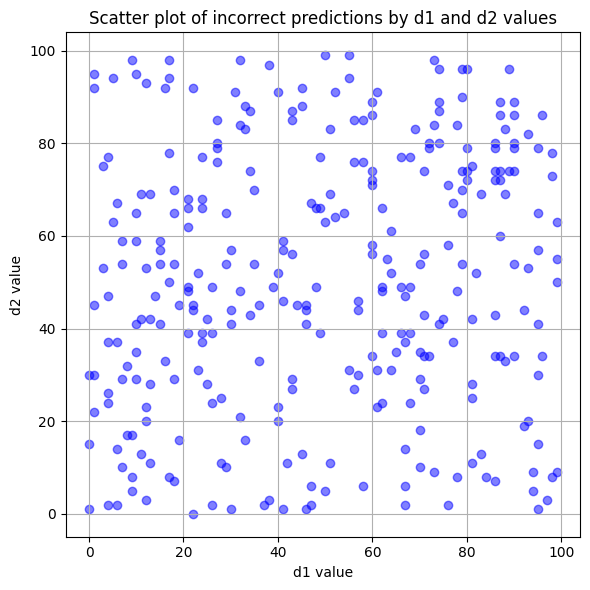

In [ ]:
# ---- Fig 6 - scatter plot ----

# Indices of incorrect samples
incorrect_idx = np.where(~all_correct)[0]

plt.figure(figsize=(6, 6))
plt.scatter(
    all_inputs[incorrect_idx, 0].detach().cpu().numpy(),
    all_inputs[incorrect_idx, 1].detach().cpu().numpy(),
    c="blue",
    alpha=0.5,
    label="Incorrect",
)
plt.xlabel("d1 value")
plt.ylabel("d2 value")
plt.title("Scatter plot of incorrect predictions by d1 and d2 values")
plt.grid(True)
plt.tight_layout()
plt.show()


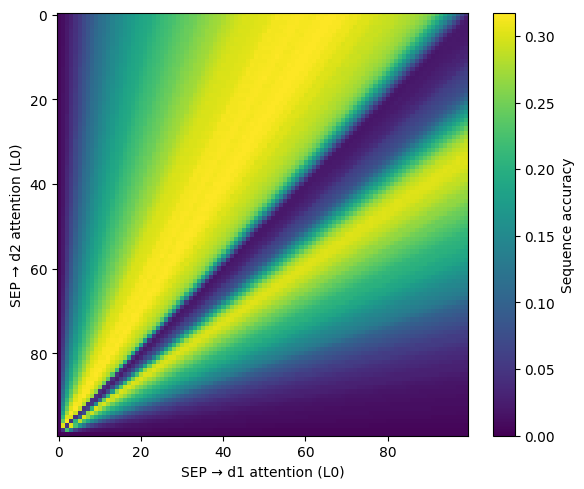

In [ ]:
# ----- Fig 7 - Performance on fixed attn patterns -----
import pickle
from functools import partial

def fixed_attention_score_hook(pattern, hook=None, attn_0=None, attn_1=None):
    # pattern: [B, H, Q, K]
    assert (attn_0 is not None) and (attn_1 is not None), "attn_0 and attn_1 must be specified"
    p0 = torch.as_tensor(attn_0, dtype=pattern.dtype, device=pattern.device)
    p1 = torch.as_tensor(attn_1, dtype=pattern.dtype, device=pattern.device)
    s = (p0 + p1).clamp_min(1e-12)

    # Clone and overwrite the SEP (q=2) row to be a valid distribution over {d1=0, d2=1}
    pattern = pattern.clone()
    pattern[..., 2, :] = 0.0
    pattern[..., 2, 0] = p0 / s
    pattern[..., 2, 1] = p1 / s
    return pattern

def sequence_accuracy_from_logits(logits, targets):
    # logits: [B, T, V], targets: [B, T]
    preds = logits.argmax(dim=-1)[:, -LIST_LEN:]          # only o1, o2
    targs = targets[:, -LIST_LEN:]
    return (preds == targs).all(dim=-1).float().mean().item()

# Inputs/targets to evaluate on
if "all_inputs" not in locals() or "all_targets" not in locals():
    all_inputs = val_ds.tensors[0].to(DEV)
    all_targets = val_ds.tensors[1].to(DEV)

steps = 100  # NOTE: 100x100 grid can be slow; reduce for quicker runs
scores = torch.linspace(0, 1, steps=steps)
cache_file = "fixed_attention_perfs.pkl"

if os.path.exists(cache_file):
    with open(cache_file, "rb") as f:
        perfs = pickle.load(f)
else:
    perfs = torch.zeros((steps, steps), dtype=torch.float32)
    for i, j in tqdm(itertools.product(range(steps), range(steps)), total=steps**2):
        logits = model.run_with_hooks(
            all_inputs,
            return_type="logits",
            fwd_hooks=[
                (
                    "blocks.0.attn.hook_pattern",
                    partial(
                        fixed_attention_score_hook,
                        attn_0=scores[i].item(),
                        attn_1=scores[j].item(),
                    ),
                )
            ],
        )
        perf = sequence_accuracy_from_logits(logits, all_targets)
        perfs[i, steps - j - 1] = perf  # flip Y so higher j is up
    with open(cache_file, "wb") as f:
        pickle.dump(perfs, f)

plt.figure(figsize=(6, 5))
plt.imshow(perfs.T.cpu(), cmap="viridis", aspect="auto", vmin=0.0)
plt.colorbar(label="Sequence accuracy")
plt.xlabel("SEP → d1 attention (L0)")
plt.ylabel("SEP → d2 attention (L0)")
plt.title("Validation performance for fixed attention scores")
plt.tight_layout()
plt.show()
